# Задание из четвёртой лабы

Обучите один из алгоритмов классификации из библиотеки sklearn. Объяснять принцип работы классификатора в этой лабораторной не требуется

1. Выберите один из датасетов первой лабораторной


2. Найдите в данных признак, который будете предсказывать
    
    Если это категория, то у неё должно быть от 2 до 10 значений (например колонка species в датасете миграции птиц содержит 3 категории)
    
    Если признак количественный, то его нужно дискретизировать (например для популярности трека в датасете spotify можно разделить треки на 3 категории: 0-20 - популярные, 21-50 - обычные, 51 - 100 - непопулярные). Полученную категорию записать в датафрейм как отдельную колонку


3. Выделите признаки для предсказания
    
    Используйте от 2 до 5 количественных признаков для предсказания целевой переменной


4. Проверьте нормальность количественных признаков
    
    Используйте статистический тест из лекции. Если распределение является лог-нормальным, логарифмируйте его и проверьте на нормальность
    
    Как минимум 1 из признаков должен быть нормальным


5. Покажите качество предсказания модели с помощью метрик

    Метрика должна учитывать баланс классов в датасете

### imports and stuff

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Data\ Analysis

/content/drive/MyDrive/Data Analysis


In [ ]:
import pandas as pd
import statistics as st
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import SGDClassifier

## preprocess data

### load

In [ ]:
df = pd.read_csv('data/spotify/SpotifyFeatures.csv')

In [ ]:
df.head(3)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.0,F#,0.151,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.0,C,0.103,-13.879,Minor,0.0362,99.488,5/4,0.368


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [ ]:
df = df.drop(['artist_name', 
              'track_name', 
              'track_id', 
              'key', 
              'time_signature', 
              'instrumentalness', 
              'duration_ms'], axis = 1)

### encode features

In [ ]:
df['genre'].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

In [ ]:
df['mode'].value_counts()

Major    151744
Minor     80981
Name: mode, dtype: int64

In [ ]:
df.head()

,genre,popularity,acousticness,danceability,energy,liveness,loudness,mode,speechiness,tempo,valence
0,Movie,0,0.611,0.389,0.910,0.3460,-1.828,Major,0.0525,166.969,0.814
1,Movie,1,0.246,0.590,0.737,0.1510,-5.559,Minor,0.0868,174.003,0.816
2,Movie,3,0.952,0.663,0.131,0.1030,-13.879,Minor,0.0362,99.488,0.368
3,Movie,0,0.703,0.240,0.326,0.0985,-12.178,Major,0.0395,171.758,0.227
4,Movie,4,0.950,0.331,0.225,0.2020,-21.150,Major,0.0456,140.576,0.390


In [ ]:
ord_enc = OrdinalEncoder()

df['genre_cat'] = ord_enc.fit_transform(df[['genre']]).astype(int)
df['mode_cat'] = ord_enc.fit_transform(df[['mode']]).astype(int)

df.head()

,genre,popularity,acousticness,danceability,energy,liveness,loudness,mode,speechiness,tempo,valence,genre_cat,mode_cat
0,Movie,0,0.611,0.389,0.910,0.3460,-1.828,Major,0.0525,166.969,0.814,15,0
1,Movie,1,0.246,0.590,0.737,0.1510,-5.559,Minor,0.0868,174.003,0.816,15,1
2,Movie,3,0.952,0.663,0.131,0.1030,-13.879,Minor,0.0362,99.488,0.368,15,1
3,Movie,0,0.703,0.240,0.326,0.0985,-12.178,Major,0.0395,171.758,0.227,15,0
4,Movie,4,0.950,0.331,0.225,0.2020,-21.150,Major,0.0456,140.576,0.390,15,0


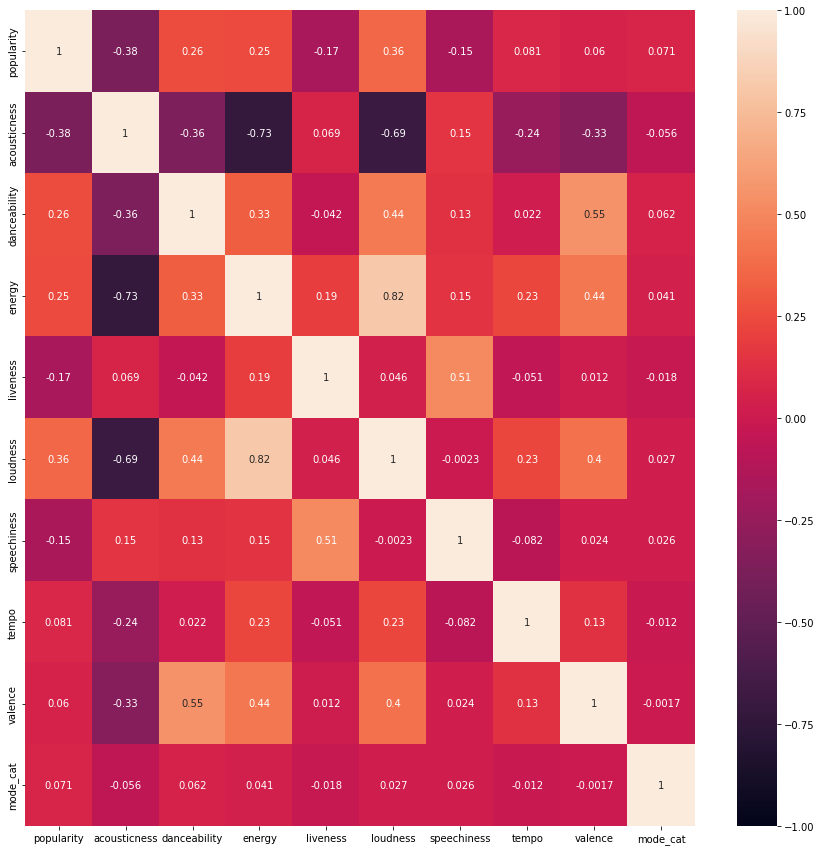

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.drop(['genre', 'genre_cat', 'mode'],axis=1).corr(), vmin=-1, vmax=1, annot=True);

### categorize target label

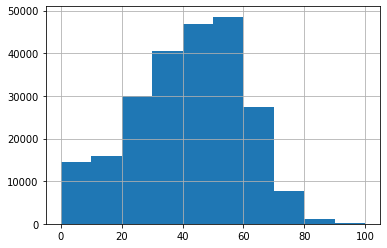

In [ ]:
df['popularity'].hist()

In [ ]:
df['popularity_cat'] = pd.qcut(df['popularity'], q=4, labels=[0,1,2,3])
df.head()

,genre,popularity,acousticness,danceability,energy,liveness,loudness,mode,speechiness,tempo,valence,genre_cat,mode_cat,popularity_cat
0,Movie,0,0.611,0.389,0.910,0.3460,-1.828,Major,0.0525,166.969,0.814,15,0,0
1,Movie,1,0.246,0.590,0.737,0.1510,-5.559,Minor,0.0868,174.003,0.816,15,1,0
2,Movie,3,0.952,0.663,0.131,0.1030,-13.879,Minor,0.0362,99.488,0.368,15,1,0
3,Movie,0,0.703,0.240,0.326,0.0985,-12.178,Major,0.0395,171.758,0.227,15,0,0
4,Movie,4,0.950,0.331,0.225,0.2020,-21.150,Major,0.0456,140.576,0.390,15,0,0


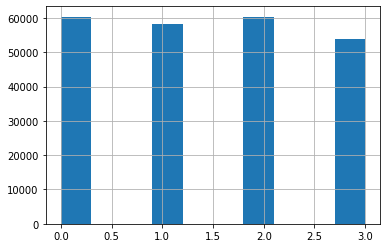

In [ ]:
df['popularity_cat'].hist()

In [ ]:
df = df[['genre_cat', 'popularity_cat', 'acousticness', 'danceability', 'energy', 'loudness']]
df.head()

,genre_cat,popularity_cat,acousticness,danceability,energy,loudness
0,15,0,0.611,0.389,0.910,-1.828
1,15,0,0.246,0.590,0.737,-5.559
2,15,0,0.952,0.663,0.131,-13.879
3,15,0,0.703,0.240,0.326,-12.178
4,15,0,0.950,0.331,0.225,-21.150


### check normality

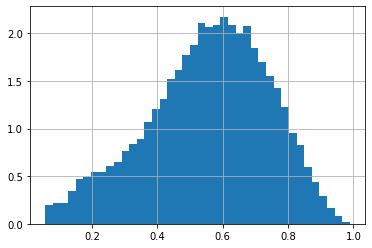

In [ ]:
df['danceability'].hist(bins=40, density=True)

In [ ]:
stats.normaltest(df['danceability'].values)

NormaltestResult(statistic=7172.387839303274, pvalue=0.0)

In [ ]:
stats.normaltest(np.log(df['danceability']).values)

NormaltestResult(statistic=72381.46890080508, pvalue=0.0)

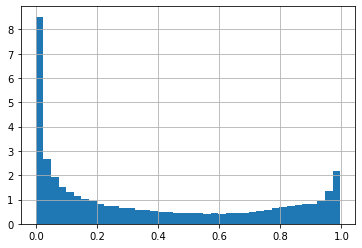

In [ ]:
df['acousticness'].hist(bins=40, density=True)

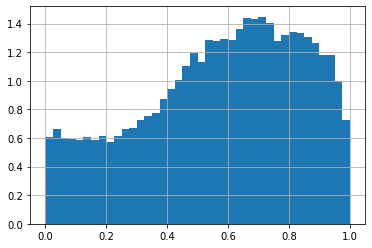

In [ ]:
df['energy'].hist(bins=40, density=True)

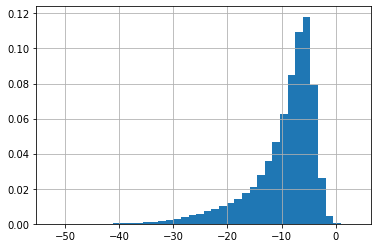

In [ ]:
df['loudness'].hist(bins=40, density=True)

## train classifiers

### predict popularity category

In [ ]:
X = df[['acousticness', 'danceability', 'energy', 'loudness']].values
y = df['popularity_cat'].values
X, y = shuffle(X, y, random_state=0)
print(X.shape, y.shape)

(232725, 4) (232725,)


In [ ]:
scoring = ['f1_weighted', 'balanced_accuracy']

sgd_clf = SGDClassifier(random_state=0)

sgd_clf_scores = cross_validate(sgd_clf, X, y, scoring=scoring)
sorted(sgd_clf_scores.keys())

['fit_time', 'score_time', 'test_balanced_accuracy', 'test_f1_weighted']

In [ ]:
sgd_clf_scores['test_balanced_accuracy'].mean()

0.337119392200924

In [ ]:
sgd_clf_scores['test_f1_weighted'].mean()

0.2702905622438642

### Predict genre

In [ ]:
most_frequent_genres = df['genre_cat'].value_counts()[:5].index.tolist()
most_frequent_genres

[7, 25, 13, 14, 17]

In [ ]:
df_gen = df[df['genre_cat'].isin(most_frequent_genres)]
df_gen['genre'] = df_gen['genre_cat'].astype('category').cat.codes
df_gen.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,genre_cat,popularity_cat,acousticness,danceability,energy,loudness,genre
92824,13,3,0.29700,0.752,0.488,-7.050,1
92825,13,3,0.01160,0.464,0.852,-3.804,1
92826,13,3,0.00847,0.560,0.936,-5.835,1
92827,13,3,0.00108,0.330,0.936,-3.660,1
92828,13,3,0.96800,0.441,0.379,-9.545,1


In [ ]:
df_gen.shape[0]

47697

In [ ]:
X = df_gen[['acousticness', 'danceability', 'energy', 'loudness']].values
y = df_gen['genre'].values
X, y = shuffle(X, y, random_state=0)
print(X.shape, y.shape)

(47697, 4) (47697,)


In [ ]:
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
forest_clf = RandomForestClassifier()

knn_acc_score = cross_val_score(knn_clf, X, y, scoring='balanced_accuracy').mean()
svm_acc_score = cross_val_score(svm_clf, X, y, scoring='balanced_accuracy').mean()
forest_acc_score = cross_val_score(forest_clf, X, y, scoring='balanced_accuracy').mean()

leaderboard = sorted([
    ('KNN', knn_acc_score),
    ('SVC', svm_acc_score),
    ('Forest', forest_acc_score)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}. {leader_name}: {leader_score}')

Leaderboard:
1. SVC: 0.6216791838057686
2. Forest: 0.607646600641439
3. KNN: 0.58654891984062


In [ ]:
df_gen[['genre', 'acousticness', 'danceability', 'energy', 'loudness']].to_csv('data/spotify/Spotify_lab4.csv')